#Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Requirements

In [ ]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.2.0+cpu.html



Looking in links: https://data.pyg.org/whl/torch-2.2.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.5/511.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.1/774.1 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.3 MB/s eta 0:00:00


#Download the dateset

In [ ]:
import os
import urllib.request

url = "https://nrvis.com/download/data/asn/mammalia-dolphin-florida-overall.zip"
dataset_zip = "mammalia-dolphin-florida-overall.zip"
filename = "mammalia-dolphin-florida-overall.edges"
output_dir = "/content/drive/MyDrive/GraphLA/results"
models_dir = "/content/drive/MyDrive/GraphLA/saved_models"
data_dir = "/content/drive/MyDrive/GraphLA/data"

os.makedirs(output_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

if not os.path.exists(dataset_zip):
    print(f"Downloading {dataset_zip}...")
    try:
        urllib.request.urlretrieve(url, dataset_zip)
        print("Download completed!")
    except Exception as e:
        print(f"Error during download: {e}")

Download completed!


#Unzip the dataset

In [ ]:
import zipfile

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
  zip_ref.extractall('.')

#Models definition

##GCN

In [ ]:
import torch.nn.functional as NNF
from torch import nn
from torch_geometric.nn import GCNConv

class StandardGCN(nn.Module):
    def __init__(self, in_feats, hidden_feats):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hidden_feats)
        self.conv2 = GCNConv(hidden_feats, hidden_feats)

    def forward(self, x, edge_index, edge_weight=None):
        h = NNF.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        h = NNF.relu(self.conv2(h, edge_index, edge_weight=edge_weight))
        return h, None

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  import torch_geometric.typing
/usr/local/

##GraphLA

In [ ]:
class LeaderScoreGNN(nn.Module):
    def __init__(self, in_feats, hidden_feats):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hidden_feats)
        self.conv2 = GCNConv(hidden_feats, 1)

    def forward(self, x, edge_index, edge_weight=None):
        h = NNF.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        h = self.conv2(h, edge_index, edge_weight=edge_weight)

        score = torch.sigmoid(h).squeeze(-1)

        deg_weighted = torch.zeros(x.size(0), device=x.device)

        if edge_weight is None:
            edge_weight = torch.ones(edge_index.size(1), device=x.device)

        deg_weighted = deg_weighted.scatter_add_(0, edge_index[0], edge_weight)
        deg_norm = deg_weighted / deg_weighted.max()

        score = score * (1 + deg_norm)

        return score


class GraphLA(nn.Module):
    def __init__(self, in_feats, hidden_feats):
        super().__init__()

        self.conv1 = GCNConv(in_feats, hidden_feats)
        self.conv2 = GCNConv(hidden_feats, hidden_feats)

        self.linear_self = nn.Linear(in_feats, hidden_feats)

        self.leader_score_net = LeaderScoreGNN(in_feats, hidden_feats // 2)

    def forward(self, x, edge_index, edge_weight=None):
        h_self = x

        h_neighbors = NNF.relu(self.conv1(x, edge_index, edge_weight=edge_weight))

        leader_score = self.leader_score_net(h_self, edge_index, edge_weight).unsqueeze(-1)

        h_self_proj = self.linear_self(h_self)

        h_new = (1 - leader_score) * h_neighbors + leader_score * h_self_proj

        h_final = NNF.relu(self.conv2(h_new, edge_index, edge_weight=edge_weight))

        return h_final, leader_score

#Utility methods

In [ ]:
import os

import matplotlib.colors as mcolors
import networkx as nx
import numpy as np
import torch
from matplotlib import pyplot as plt
import pickle
import random
import sys
from os import path

import networkx as nx
import torch

def plot_edge_prediction_graph(G, model, x, edge_index, edge_weight, node_id_to_idx, model_name ,save=True):
    with torch.no_grad():
        embeddings, leader_score = model(x, edge_index, edge_weight)

    edge_probs = {(u, v): torch.sigmoid(edge_score(node_id_to_idx[u], node_id_to_idx[v], embeddings)).item() for u, v in G.edges}

    edges, probs = zip(*edge_probs.items())
    vmin, vmax = min(probs), max(probs)

    fig, ax = plt.subplots(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue', ax=ax)

    nx.draw_networkx_edges(
        G, pos, edgelist=edges, edge_color=probs,
        edge_cmap=plt.cm.viridis, edge_vmin=vmin, edge_vmax=vmax, width=2, ax=ax
    )

    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label="Link probability")

    if save:
      path.join(output_dir, f'{os.path.splitext(filename)[0]}_{model_name}.png')

    plt.title("Link prediction")
    plt.axis("off")
    plt.show()


def plot_models_comparison(df_gla, df_gcn, dataset_path, results_dir, gla_name="GraphLA", gcn_name="GraphGCN"):
    df_gla = df_gla.rename(columns={0: gla_name})
    df_gcn = df_gcn.rename(columns={0: gcn_name})

    df_combined = pd.concat([df_gla, df_gcn], axis=1)

    improvement = ((df_combined[gla_name] - df_combined[gcn_name]) /
                   df_combined[gcn_name] * 100).round(2).astype(str) + "%"

    df_final = df_combined.assign(**{"Improvement (%)": improvement})

    print("\nFinal comparison summary\n", df_final)

    base_name = os.path.splitext(os.path.basename(dataset_path))[0]

    csv_path = os.path.join(results_dir, f"{base_name}_models_comparison.csv")
    df_final.to_csv(csv_path, index=True)

    metrics = df_combined.index
    x = np.arange(len(metrics))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, df_combined[gla_name], width=width, label=gla_name)
    plt.bar(x + width/2, df_combined[gcn_name], width=width, label=gcn_name)

    plt.xticks(x, metrics, rotation=45)
    plt.ylabel('Score')
    plt.title(f'Comparison of {gla_name} vs {gcn_name}')
    plt.legend(loc='lower right')
    plt.tight_layout()

    graph_path = os.path.join(results_dir, f"{base_name}_models_comparison_graph.png")
    plt.savefig(graph_path, dpi=300)
    plt.show()

    return df_final


def load_model(model, model_path):
    if not path.isfile(model_path):
        print(f"Error: the model '{model_path}' doesn't exists, please generate it with model_training.py file")
        sys.exit(1)

    if path.getsize(model_path) == 0:
        print(f"Error: the model '{model_path}' is empty")
        sys.exit(1)

    try:
        model.load_state_dict(torch.load(model_path, weights_only=True))
    except Exception as e:
        print(f"Error loading model '{model_path}': {e}")
        sys.exit(1)

def load_training_set(pos_path: str = os.path.join(data_dir, 'positive_edges.pkl'), neg_path: str = os.path.join(data_dir, 'negative_edges.pkl')):
    with open(pos_path, "rb") as f:
        pos_edges = pickle.load(f)

    with open(neg_path, "rb") as f:
        possible_neg_edges = pickle.load(f)

    return pos_edges, possible_neg_edges


def prepare_graph_inputs(graph_file):
    G = load_graph(graph_file)
    node_list = list(G.nodes)
    node_id_to_idx = {n: i for i, n in enumerate(node_list)}

    closeness = nx.closeness_centrality(G, distance='weight')
    betweenness = nx.betweenness_centrality(G, weight='weight')

    x = torch.tensor([
        [G.degree(n),
         sum(G[n][nbr]["weight"] for nbr in G.neighbors(n))]
        for n in G.nodes
    ], dtype=torch.float)

    x = (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

    edge_index = torch.tensor([[node_id_to_idx[u], node_id_to_idx[v]] for u, v in G.edges],
                              dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor([G[u][v]["weight"] for u, v in G.edges], dtype=torch.float)

    return G, x, edge_index, edge_weight


def prepare_training_set(pos_edges, possible_neg_edges):
    num_neg = len(pos_edges)
    neg_edges = random.sample(possible_neg_edges, min(num_neg, len(possible_neg_edges)))

    edges_all = pos_edges + neg_edges
    labels_all = [1] * len(pos_edges) + [0] * len(neg_edges)

    combined = list(zip(edges_all, labels_all))
    random.shuffle(combined)
    edges_all, labels_all = zip(*combined)

    edges_all = torch.tensor(edges_all, dtype=torch.long)
    labels_all = torch.tensor(labels_all, dtype=torch.float)

    return edges_all, labels_all


def load_graph(file_path: str) -> nx.Graph:
    if not path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    G = nx.Graph()
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            u, v = parts[0], parts[1]
            w = float(parts[2])
            G.add_edge(u, v, weight=w)

    return G


#Training methods

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import KFold
from tqdm import tqdm

def split_edges_train_val_test(edges_all, labels, test_size=0.2, random_state=42):
    from sklearn.model_selection import train_test_split

    edges_list = list(edges_all)
    labels_list = list(labels)

    train_val_edges, test_edges, train_val_labels, test_labels = train_test_split(
        edges_list, labels_list, test_size=test_size, random_state=random_state
    )

    train_val_edges = torch.tensor([list(e) for e in train_val_edges], dtype=torch.long)
    test_edges = torch.tensor([list(e) for e in test_edges], dtype=torch.long)

    train_val_labels = torch.tensor(train_val_labels, dtype=torch.float)
    test_labels = torch.tensor(test_labels, dtype=torch.float)

    return train_val_edges, train_val_labels, test_edges, test_labels

def edge_score(u, v, embeddings):
    u = int(u)
    v = int(v)
    return (embeddings[u] * embeddings[v]).sum()

def compute_loss(model, x, edge_index, edge_weight, edges, labels):
    embeddings, leader_score = model(x, edge_index, edge_weight)
    preds = torch.stack([edge_score(u, v, embeddings) for u, v in edges])

    loss_fn = torch.nn.BCEWithLogitsLoss()
    loss = loss_fn(preds, labels)

    preds_sigmoid = torch.sigmoid(preds)
    return loss, preds_sigmoid

def evaluate_on_edges(model, x, edge_index, edge_weight, edges, labels):
    model.eval()
    with torch.no_grad():
        embeddings, _ = model(x, edge_index, edge_weight)
        preds = torch.stack([torch.sigmoid((embeddings[int(u)] * embeddings[int(v)]).sum()) for u, v in edges])

        loss_fn = torch.nn.BCELoss()
        loss = loss_fn(preds, labels)

        from sklearn.metrics import precision_recall_curve
        precision_curve, recall_curve, thresholds = precision_recall_curve(labels.numpy(), preds.numpy())
        f1_scores = 2 * precision_curve[:-1] * recall_curve[:-1] / (precision_curve[:-1] + recall_curve[:-1] + 1e-8)
        best_threshold = thresholds[f1_scores.argmax()]

        pred_labels = (preds >= best_threshold).float()
        labels_np = labels.numpy()
        pred_labels_np = pred_labels.numpy()

        from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score
        auc = roc_auc_score(labels_np, preds.numpy())
        ap = average_precision_score(labels_np, preds.numpy())
        precision = precision_score(labels_np, pred_labels_np)
        recall = recall_score(labels_np, pred_labels_np)
        f1 = f1_score(labels_np, pred_labels_np)

    return {
        "AUC": auc,
        "AP": ap,
        "Precision": precision,
        "Recall": recall,
        "Loss": loss.item()
    }

def train_kfold(
        model_class, base_params, x, edge_index, edge_weight,
        edges_train_val, labels_train_val,
        edges_test, labels_test,
        param_grid, k=5, epochs=20
):
    best_ap = -1
    best_params = None
    results = []

    for params in param_grid:
        lr = params.get("lr", 0.01)
        h_feats = params.get("hidden_feats", base_params.get("hidden_feats", 32))

        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        aps = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(edges_train_val)):
            model_fold = model_class(in_feats=base_params['in_feats'], hidden_feats=h_feats)

            optimizer = torch.optim.Adam(model_fold.parameters(), lr=lr, weight_decay=5e-4)

            edges_train, labels_train = edges_train_val[train_idx], labels_train_val[train_idx]
            edges_val, labels_val = edges_train_val[val_idx], labels_train_val[val_idx]

            for epoch in range(epochs):
                model_fold.train()
                optimizer.zero_grad()
                train_loss, _ = compute_loss(model_fold, x, edge_index, edge_weight, edges_train, labels_train)
                train_loss.backward()
                optimizer.step()

            metrics = evaluate_on_edges(model_fold, x, edge_index, edge_weight, edges_val, labels_val)
            aps.append(metrics['AP'])

        avg_ap = sum(aps) / k
        results.append({**params, "avg_ap": avg_ap})

        if avg_ap > best_ap:
            best_ap = avg_ap
            best_params = params

    final_model = model_class(in_feats=base_params['in_feats'], hidden_feats=best_params['hidden_feats'])
    optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['lr'])

    for epoch in tqdm(range(epochs), desc="Training final model"):
        final_model.train()
        optimizer.zero_grad()
        train_loss, _ = compute_loss(final_model, x, edge_index, edge_weight, edges_train_val, labels_train_val)
        train_loss.backward()
        optimizer.step()

    test_metrics = evaluate_on_edges(final_model, x, edge_index, edge_weight, edges_test, labels_test)

    return final_model, best_params, test_metrics


#Main

GraphLA model training in progress...

Parameters:
                   0       1       2       3
lr             0.010   0.010   0.005   0.005
hidden_feats  16.000  32.000  16.000  32.000
avg_ap         0.889   0.913   0.888   0.892

Best parameters:
lr               0.010
hidden_feats    32.000
avg_ap           0.913
Name: 1, dtype: float64



Training final model: 100%|██████████| 50/50 [00:01<00:00, 41.06it/s]



Test summary 
                   0
AUC        0.911932
AP         0.915064
Precision  0.947368
Recall     0.818182
Loss       0.496063


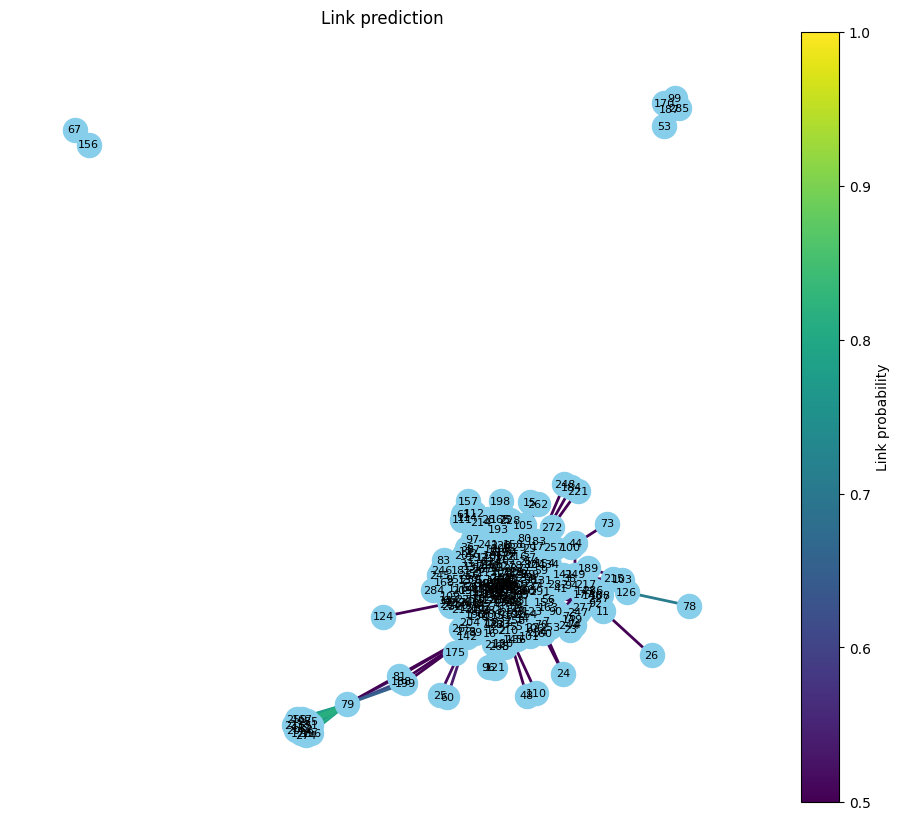

Saving GraphLA model...
Model GraphLA saved successfully...

GCN model training in progress...

Parameters:
                   0       1       2       3
lr             0.010   0.010   0.005   0.005
hidden_feats  16.000  32.000  16.000  32.000
avg_ap         0.852   0.871   0.837   0.893

Best parameters:
lr               0.005
hidden_feats    32.000
avg_ap           0.893
Name: 3, dtype: float64



Training final model: 100%|██████████| 50/50 [00:01<00:00, 30.20it/s]



Test summary 
                   0
AUC        0.897727
AP         0.905138
Precision  1.000000
Recall     0.818182
Loss       0.495010


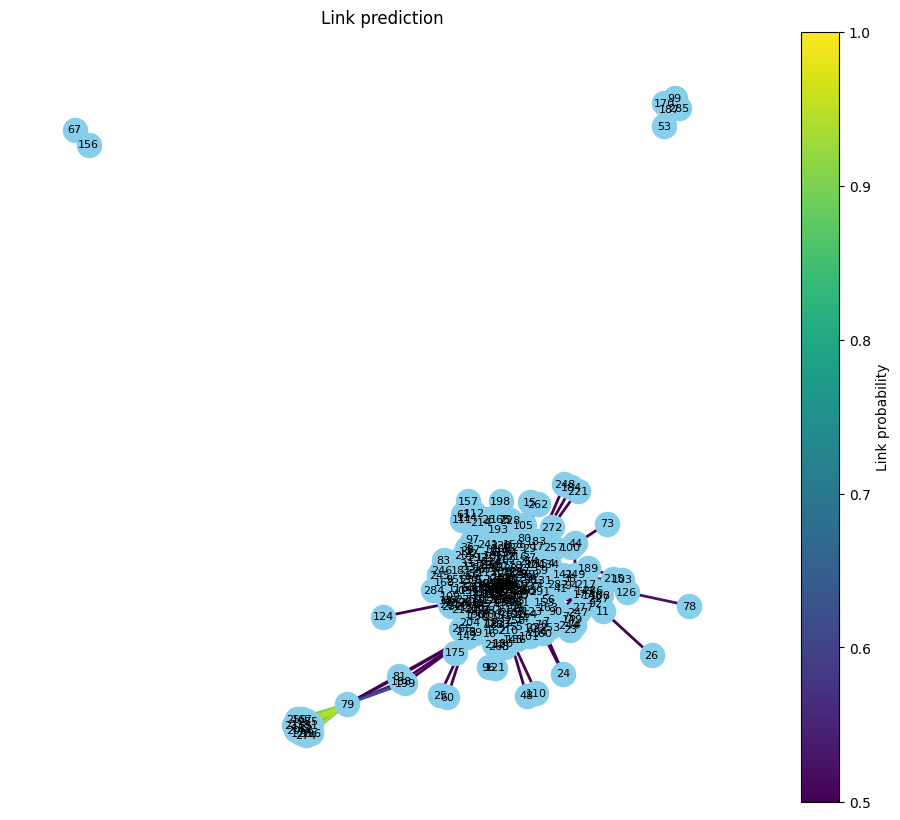

Saving GraphGCN model...
Model GraphGCN saved successfully...

Final comparison summary
             GraphLA  GraphGCN Improvement (%)
AUC        0.911932  0.897727           1.58%
AP         0.915064  0.905138            1.1%
Precision  0.947368  1.000000          -5.26%
Recall     0.818182  0.818182            0.0%
Loss       0.496063  0.495010           0.21%


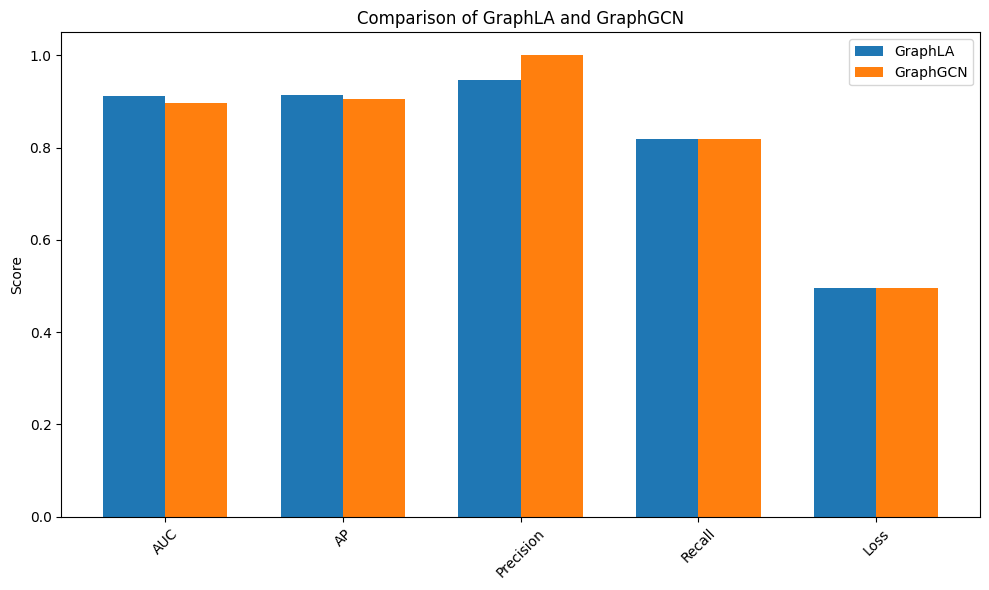

In [ ]:
import os
import random
from os import path

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# 1) Create input data for GNN
G, x, edge_index, edge_weight = prepare_graph_inputs(filename)

node_list = list(G.nodes)
node_id_to_idx = {n: i for i, n in enumerate(node_list)}

# 2) Load and prepare training set
pos_edges, possible_neg_edges = load_training_set()

edges_all, labels_all = prepare_training_set(pos_edges, possible_neg_edges)

# Split in train, val and test sets
train_val_edges, train_val_labels, test_edges, test_labels = split_edges_train_val_test(edges_all, labels_all)

# parameters for k fold
base_params = {"in_feats": x.size(1)}

param_grid = [
    {"lr": 0.01, "hidden_feats": 16},
    {"lr": 0.01, "hidden_feats": 32},
    {"lr": 0.005, "hidden_feats": 16},
    {"lr": 0.005, "hidden_feats": 32}
]

# 3) Train, evaluate and test GraphLA
print("GraphLA model training in progress...")
# GraphLA
final_model, _, test_metrics = train_kfold(
    GraphLA,
    base_params,
    x, edge_index, edge_weight,
    train_val_edges, train_val_labels,
    test_edges, test_labels,
    param_grid,
    k=5,
    epochs=50
)

df_test_GLA = pd.DataFrame([test_metrics]).T
print(f'\nTest summary \n {df_test_GLA}')

plot_edge_prediction_graph(G, final_model, x, edge_index, edge_weight, node_id_to_idx, "graphLA")

print("Saving GraphLA model...")
torch.save(final_model.state_dict(), path.join(models_dir, f'{os.path.splitext(filename)[0]}_graphLA.pt'))
print("Model GraphLA saved successfully...")


# 4) Train, evaluate and test StandardGCN
print("\nGCN model training in progress...")
# Standard GCN
final_model, _, test_metrics = train_kfold(
    StandardGCN,
    base_params,
    x, edge_index, edge_weight,
    train_val_edges, train_val_labels,
    test_edges, test_labels,
    param_grid,
    k=5,
    epochs=50
)

df_test_GCN = pd.DataFrame([test_metrics]).T
print(f'\nTest summary \n {df_test_GCN}')

plot_edge_prediction_graph(G, final_model, x, edge_index, edge_weight, node_id_to_idx, "GCN")

print("Saving GraphGCN model...")
torch.save(final_model.state_dict(), path.join(models_dir, f'{os.path.splitext(filename)[0]}_graphGCN.pt'))
print("Model GraphGCN saved successfully...")


# 5) Final comparison
df_final = plot_models_comparison(
    df_test_GLA,
    df_test_GCN,
    data_dir,
    output_dir
)